In [0]:
# preparation
import tensorflow as tf
from tensorflow import keras 
# Common imports
import numpy as np
import pandas as pd
from copy import deepcopy as copy
import pickle
import os
import cv2
#os.environ['KMP_DUPLICATE_LIB_OK']='True'   #TF2: to fix Jupyter down

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
from sklearn.utils import shuffle
import IPython.display as ipd  # for display and clear_output

In [0]:
tf.__version__

'2.2.0-rc3'

In [0]:
#!unzip /animals10.zip

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
filenames_dog = os.listdir("/content/drive/My Drive/Colab Notebooks/cane")
filenames_nondog = os.listdir("/content/drive/My Drive/Colab Notebooks/ragno")

In [0]:
#add the prefix to filenames
prefix = "/content/drive/My Drive/Colab Notebooks/cane/"
filenames_dog = [str(prefix + x) for x in filenames_dog]
prefix = "/content/drive/My Drive/Colab Notebooks/ragno/"
filenames_nondog = [str(prefix + x) for x in filenames_nondog]

In [0]:
df_dog = pd.DataFrame({
    'filename': filenames_dog,
    'category': 0
})

df_dog.shape

(4863, 2)

In [0]:
df_nondog = pd.DataFrame({
    'filename': filenames_nondog,
    'category': 1
})

df_nondog.shape

(2301, 2)

In [0]:
df_dog = df_dog[:2400]
df_dog.shape

(2400, 2)

In [0]:
df = [df_nondog, df_dog]
df = pd.concat(df)
df = shuffle(df)
df

,filename,category
540,/content/drive/My Drive/Colab Notebooks/cane/O...,0
1855,/content/drive/My Drive/Colab Notebooks/cane/O...,0
189,/content/drive/My Drive/Colab Notebooks/cane/O...,0
883,/content/drive/My Drive/Colab Notebooks/cane/O...,0
1066,/content/drive/My Drive/Colab Notebooks/ragno/...,1
...,...,...
63,/content/drive/My Drive/Colab Notebooks/cane/O...,0
1388,/content/drive/My Drive/Colab Notebooks/cane/O...,0
1767,/content/drive/My Drive/Colab Notebooks/cane/O...,0
99,/content/drive/My Drive/Colab Notebooks/cane/O...,0


In [0]:
df['category'].value_counts()

0    2400
1    2301
Name: category, dtype: int64

In [0]:
def normorlize(df, num = 4000):
    '''
    get part of the sample
    And change the category to target,'0' and not target. '1',
    Because the there has 10 category, it is a lot of work to train the model.
    '''

    df_target = df[:num] ## (num, 224,224,3)
    df_other = df[num:]  ##take the rest
    df_other['category'] = df_other['category'].apply(lambda x: 1 if x!=0 else 0) 
    df_other = shuffle(df_other) ##shuffle the rest
    df_other = df_other[num:]  ##Take part of other, so the target and other will be closed to 50%, 50%
    df = [df_target, df_other] ##combine the target and other
    df = pd.concat(df)

    return df

def ReadImgConvertnpArray(df):
    '''
    Store the image to np array
    input: pandas datafram
    output:(num,224,224,3) numpy array
    '''
    images = []
    num = 0
    for files in df['filename']:
        img = cv2.imread(files)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(112,112))
        images.append(img) 
    images = np.array(images)
    return images

def splitData(images,df,ratio = 0.8):
    training_num = images[0]*ratio
    category_array = np.array(df['category'])

    x_train = images[:training_num,:]
    y_train = category_array[:training_num,:]

    x_test = images[training_num:,:]
    y_test = category_array[training_num:,:]
    print("Training data shape:{}".format(x_train.shape))
    print("Training label shape:{}".format(y_train.shape))
    print("Testing data shape:{}".format(x_test.shape))
    print("Testing data shape:{}".format(y_test.shape))

    return x_train, y_train, x_test, y_test

In [0]:
images = ReadImgConvertnpArray(df)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
#Print out images shape
images.shape
##(images, imges size(224,224),(RBG))

(4701, 112, 112, 3)

In [0]:
x_train = images[:1200,:]
x_train.shape

(1200, 112, 112, 3)

In [0]:
y_train = np.array(df['category'])
y_train = y_train[:1200,]
y_train.shape

(1200,)

In [0]:
x_test = images[1200:,:]
x_test.shape

(3501, 112, 112, 3)

In [0]:
y_test = np.array(df['category'])
y_test = y_test[1200:,]
y_test.shape

(3501,)

 Store the number of samples for both the training and test data.

In [0]:
Ntrain, Ntest = x_train.shape[0], x_test.shape[0]

Plots image data and their labels.

In [0]:
n_label = ['dog','not dog']
def plot_image(image, name):
    plt.imshow(image, cmap="binary")
    plt.title(name)
    plt.axis("off")
def plot_Images(x, y, n):
    plt.figure(figsize=(12,12))
    nr = int(np.ceil(np.sqrt(n)))
    
    # Remove channel dimension for plotting
    if len(x.shape) > 3:
        x = x.squeeze()
        
    for i in range(n):
        plt.subplot(nr, nr, 1 + i)
        plot_image(x[i], n_label[y[i]])
    plt.tight_layout()

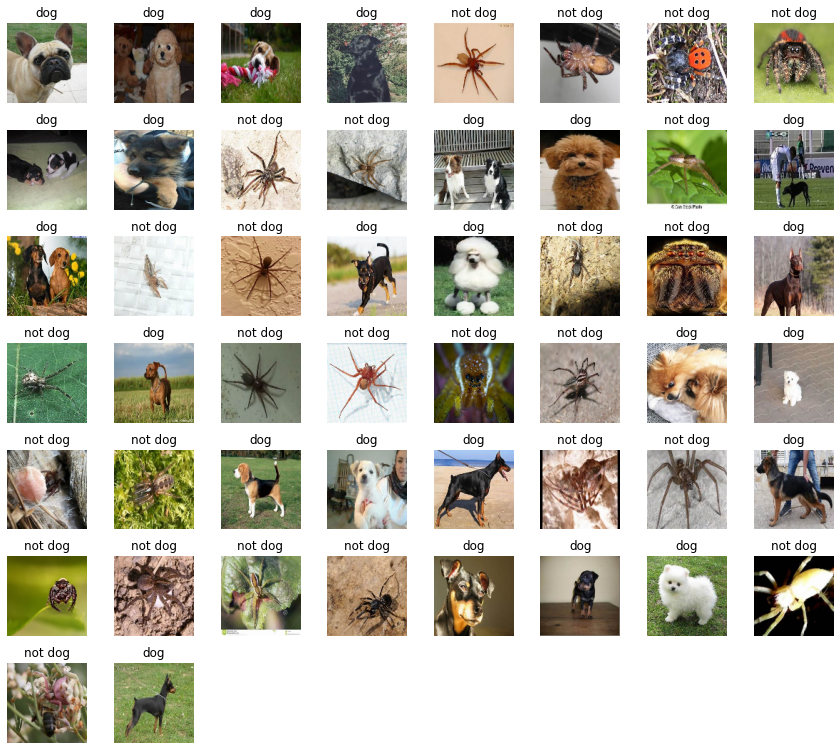

In [0]:
plot_Images(x_train,y_train,50)

In [0]:
##using VGG16 model.
base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(112,112,3))

add_model = keras.Sequential()
add_model.add(keras.layers.Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(keras.layers.Dense(256, activation='relu'))
add_model.add(keras.layers.Dense(2, activation='softmax'))

model = keras.Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer= keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 56, 56, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 56, 56, 128)       147584    
______________________________________________________________

In [0]:
batch_size = 32
epochs = 5

train_datagen = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)


history = model.fit(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[keras.callbacks.ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc')]
)

Epoch 1/5
37/37 [==============================] - ETA: 0s - loss: 1.8246 - accuracy: 0.4949 WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: VGG16-transferlearning.model/assets
37/37 [==============================] - 953s 26s/step - loss: 1.8246 - accuracy: 0.4949 - val_loss: 0.6975 - val_accuracy: 0.5798
Epoch 2/5
37/37 [==============================] - 955s 26s/step - loss: 0.6936 - accuracy: 0.5445 - val_loss: 0.6948 - val_accuracy: 0.5181
Epoch 3/5
37/37 [==============================] - 945s 26s/step - loss: 0.6934 - accuracy: 0.5248 - val_loss: 0.6946 - val_accuracy: 0.5298
Epoch 4/5
37/37 [==============================] - 945s 26s/step -

Text(0, 0.5, 'loss')

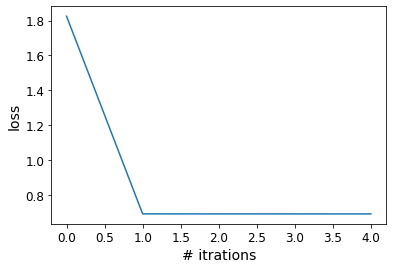

In [0]:
plt.plot(history.history['loss'])
plt.xlabel("# itrations")
plt.ylabel("loss")

In [0]:
score = model.evaluate(x_test,y_test)
score

110/110 [==============================] - 395s 4s/step - loss: 0.6944 - accuracy: 0.5376


[0.6944108605384827, 0.5375607013702393]

In [0]:
Ytest_probs = model.predict(x_test)
# TODO (3)
Ytest_preds = np.argmax(Ytest_probs, axis = 1)

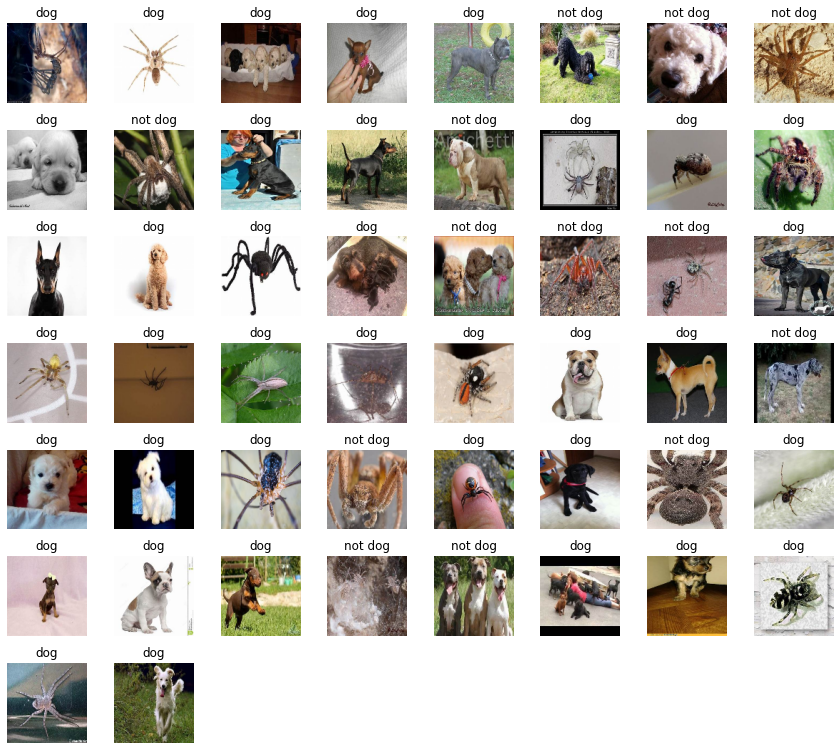

In [0]:
plot_Images(x_test,Ytest_preds,n=50)

In [0]:
def windows(image, windows_x, windows_y):
    windowSize = [windows_x, windows_y]
    windows_list = []
    windows_location = 0
    for y in range(0, image.shape[0], 100):
            for x in range(0, image.shape[1], 100):
                img = image[y:y + windowSize[1], x:x + windowSize[0]]
                img = cv2.resize(img,(112,112))
                #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                windows_list.append(img)
    return windows_list

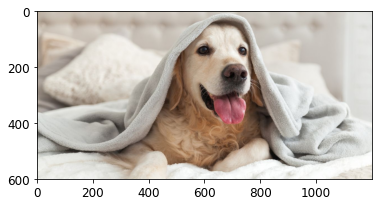

In [0]:
image = cv2.imread('/content/drive/My Drive/Colab Notebooks/dog2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image,cmap = 'binary')

In [0]:
list_windows = np.array(windows(image,224,224))
list_windows.shape

(84, 112, 112, 3)

In [0]:
Ytest_probs = model.predict(list_windows)
Ytest_preds = np.argmax(Ytest_probs, axis = 1)

In [0]:
preds =pd.DataFrame(Ytest_preds)
preds[0].value_counts()

0    61
1    23
Name: 0, dtype: int64

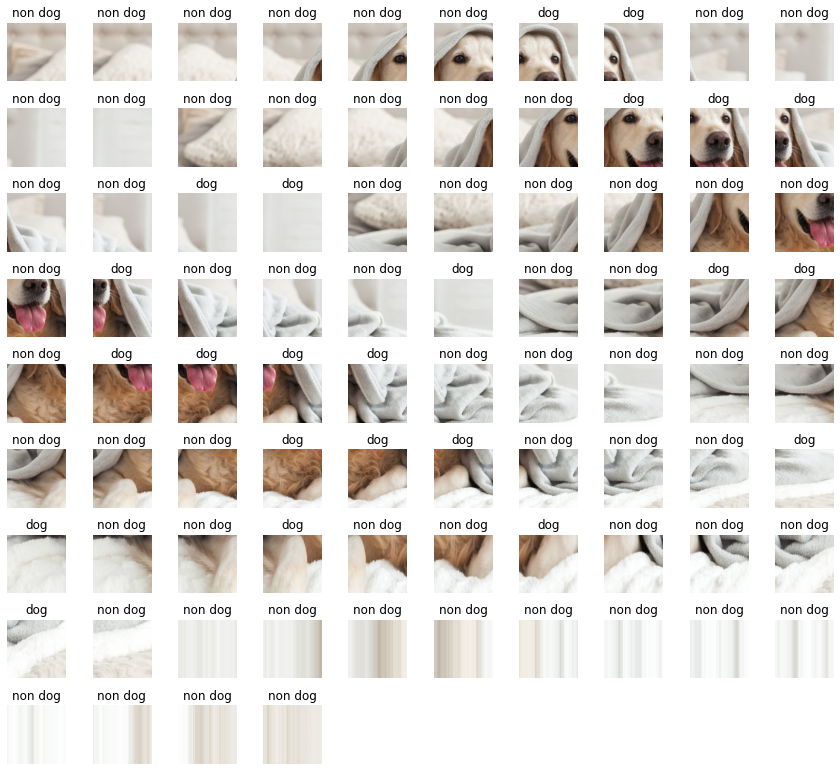

In [0]:
plot_Images(list_windows,Ytest_preds,n=84)

In [0]:
Ytest_preds

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
preds = Ytest_preds.copy()
preds = preds.tolist()
index = [i for i, x in enumerate(preds) if x == 1]

In [0]:
final_index = []
for i in range(len(Ytest_preds)):
    if Ytest_preds[i] == 1 :
        if i+1 < len(Ytest_preds) and Ytest_preds[i] == Ytest_preds[i+1]:
            final_index.append(i)

In [0]:
final_index

[6, 17, 18, 22, 38, 41, 42, 43, 53, 54, 59]

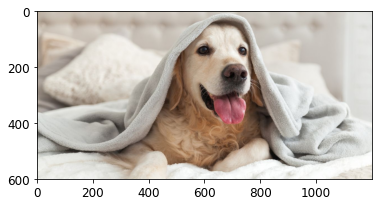

In [0]:
def draw_rectangle(image, windows_x, windows_y, index):
    windowSize = [windows_x, windows_y]
    rectangle_location = 0
    for y in range(0, image.shape[0], 100):
            for x in range(0, image.shape[1], 100):
                if index == rectangle_location:
                    img = image[y:y + windowSize[1], x:x + windowSize[0]]
                    image = cv2.rectangle(image, (x,y), (x+windows_x, y+windows_y), color = (0,0,0), thickness = 5)
                rectangle_location = rectangle_location + 1
    return image
image = cv2.imread('/content/drive/My Drive/Colab Notebooks/dog2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image,cmap = 'binary')

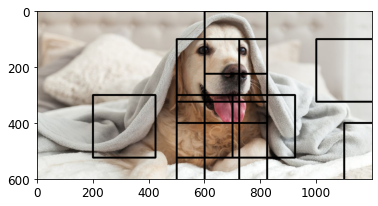

In [0]:
for i in final_index:
    image = draw_rectangle(image,224, 224,i)
plt.imshow(image,cmap = 'binary')

**Additional**

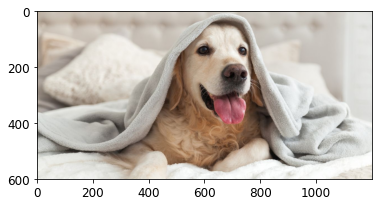

In [0]:
image = cv2.imread('/content/drive/My Drive/Colab Notebooks/dog2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image,cmap = 'binary')

In [0]:
def draw_heatmap(image, index, windows_x = 224, windows_y = 224):
    windowSize = [windows_x, windows_y]
    rectangle_location = 0
    for y in range(0, image.shape[0], 100):
            for x in range(0, image.shape[1], 100):
                if index == rectangle_location:
                    image[y:y + windowSize[1], x:x + windowSize[0]] += 1
                rectangle_location = rectangle_location + 1
    return image

In [0]:
def draw_heatmap(image, index, windows_x = 224, windows_y = 224):
    windowSize = [windows_x, windows_y]
    rectangle_location = 0
    for y in range(0, image.shape[0], 100):
            for x in range(0, image.shape[1], 100):
                if index == rectangle_location:
                    image[y:y + windowSize[1], x:x + windowSize[0]] += 1
                rectangle_location = rectangle_location + 1
    return image

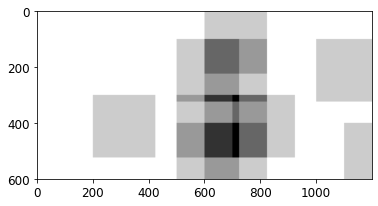

In [0]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

for i in final_index:
    heat = draw_heatmap(heat,i)

plt.imshow(heat,cmap = 'binary')

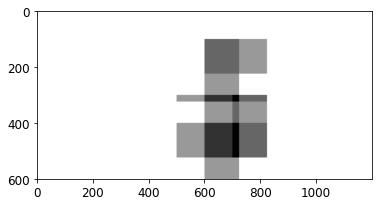

In [0]:
# applying a threshold value to the image to filter out low pixel cells
def apply_threshold(heat, threshold):
    heat[heat <= threshold] = 0
    return heat

heat = apply_threshold(heat,1)
plt.imshow(heat,cmap = 'binary')

In [0]:
heat.shape

(601, 1200)

In [0]:
heat

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [0]:
#Find heatmap position:
def FinalPosition(heat):
    min_x = 9999
    min_y = 9999
    max_x = 0
    max_y = 0
    for y in range(heat.shape[0]):
            for x in range(heat.shape[1]):
                if heat[y][x] > 0 :
                    if x < min_x:
                        min_x = x
                    if y < min_y:
                        min_y = y
                    if x > max_x:
                        max_x = x
                    if y > max_y:
                        max_y = y
    return min_x, min_y, max_x, max_y

In [0]:
min_x, min_y, max_x, max_y = FinalPosition(heat)

In [0]:
heat2 = heat.copy()

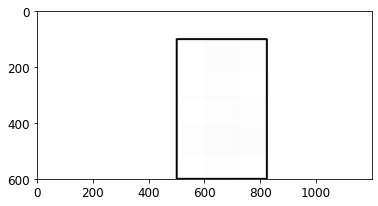

In [0]:
result_test = cv2.rectangle(heat2, (min_x,min_y), (max_x,max_y), color = (225,255,255), thickness = 5)
plt.imshow(result_test,cmap = 'binary')

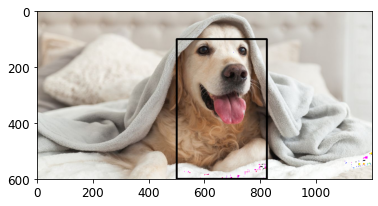

In [0]:
result = cv2.rectangle(image, (min_x,min_y), (max_x,max_y), color = (0,0,0), thickness = 5)
plt.imshow(result,cmap = 'binary')